In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import utils

In [32]:
from pathlib import Path
current_working_directory = Path.cwd()

In [33]:
ENERGY_METRICS = ['PACKAGE_ENERGY (J)', 'DRAM_ENERGY (J)']

In [34]:
DATAPATH = f"../experiments/gl2_data.csv"

In [35]:
data = pd.read_csv(DATAPATH)

In [36]:
data.columns

Index(['subject', 'target', 'cache-references', 'cache-misses', 'LLC-loads',
       'LLC-load-misses', 'LLC-stores', 'LLC-store-misses',
       'cache-misses_percent', 'LLC-load-misses_percent',
       'LLC-store-misses_percent', 'DRAM_ENERGY (J)', 'PACKAGE_ENERGY (J)',
       'PP0_ENERGY (J)', 'PP1_ENERGY (J)', 'TOTAL_MEMORY', 'TOTAL_SWAP',
       'USED_MEMORY', 'USED_SWAP', 'execution_time', 'PROCESS_CPU_USAGE',
       'PROCESS_MEMORY', 'PROCESS_VIRTUAL_MEMORY', 'CPU_USAGE_0',
       'CPU_USAGE_1', 'CPU_USAGE_2', 'CPU_USAGE_3', 'CPU_FREQUENCY_0',
       'CPU_FREQUENCY_1', 'CPU_FREQUENCY_2', 'CPU_FREQUENCY_3'],
      dtype='object')

In [37]:
# Convert to KJ and add Total Energy
data['PACKAGE_ENERGY (J)'] = data['PACKAGE_ENERGY (J)'] / 1000
data['DRAM_ENERGY (J)'] = data['DRAM_ENERGY (J)'] / 1000
data['PP0_ENERGY (J)'] = data['PP0_ENERGY (J)'] / 1000
data['TOTAL_ENERGY'] = data['PACKAGE_ENERGY (J)'] + data['DRAM_ENERGY (J)']
data['CACHE_ENERGY'] = data['PACKAGE_ENERGY (J)'] - data['PP0_ENERGY (J)']
data.rename(
    columns={'PACKAGE_ENERGY (J)': 'PACKAGE_ENERGY (KJ)', 'DRAM_ENERGY (J)': 'DRAM_ENERGY (KJ)', 'PP0_ENERGY (J)': 'PP0_ENERGY (KJ)' }, inplace=True
)

In [38]:
ENERGY_METRICS = ['PACKAGE_ENERGY (J) (KJ)', 'DRAM_ENERGY (KJ)', 'TOTAL_ENERGY']

In [39]:
subjects = list(set(data['subject'].values))
targets = list(set(data['target'].values))

GROUPS = list(
    product(subjects, targets)
)

In [40]:
data['subject'] = pd.Categorical(
    data['subject'],
    ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
)

## Descriptive Statistics

### Descriptive Statistics per Benchmark

In [41]:
def reform(dictionary):
    return {(outerKey, innerKey): values for outerKey, innerDict in dictionary.items() for innerKey, values in innerDict.items()}

In [42]:
descriptive = []
for subject in subjects:
    row = {}
    row['subject'] = subject

    for target in targets:
        df = utils.get_rows_by_subject_target(data, subject, target)
        #stats = {'subject': subject, 'target' : target} | reform(df[ENERGY_METRICS].describe().to_dict())

        row[(target, 'PACKAGE')] = df['PACKAGE_ENERGY (KJ)'].mean()
        row[(target, 'DRAM')] = df['DRAM_ENERGY (KJ)'].mean()
        row[(target, 'CACHE')] = df['CACHE_ENERGY'].mean()
        row[(target, 'CPU')] = df['PP0_ENERGY (KJ)'].mean()
        
    descriptive.append(row)

#columns = pd.MultiIndex.from_product([targets, ['CPU', 'DRAM']])
table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,"(fannkuch_redux, PACKAGE)","(fannkuch_redux, DRAM)","(fannkuch_redux, CACHE)","(fannkuch_redux, CPU)","(k_nucleotide, PACKAGE)","(k_nucleotide, DRAM)","(k_nucleotide, CACHE)","(k_nucleotide, CPU)","(spectralnorm, PACKAGE)",...,"(binary_trees, CACHE)","(binary_trees, CPU)","(n_body, PACKAGE)","(n_body, DRAM)","(n_body, CACHE)","(n_body, CPU)","(mandelbrot, PACKAGE)","(mandelbrot, DRAM)","(mandelbrot, CACHE)","(mandelbrot, CPU)"
7,codon,0.724269,0.323172,0.548285,0.175984,0.673663,0.302561,0.505618,0.168045,0.071039,...,0.204072,0.068413,0.074627,0.034783,0.057743,0.016885,1.005466,0.445068,0.759278,0.246188
1,cpython,32.751884,13.303857,23.678989,9.072895,3.994630,1.668825,2.907978,1.086652,6.410312,...,11.191816,3.352841,7.902677,3.197547,5.666114,2.236563,12.391790,5.096238,9.086651,3.305139
4,cython,23.517113,9.593737,17.118507,6.398606,3.465569,1.460863,2.536397,0.929172,4.653322,...,9.829187,2.828407,13.470235,5.515373,9.776047,3.694187,10.933134,4.551181,8.111365,2.821768
6,mypyc,31.578327,12.974213,23.081754,8.496573,4.046222,1.698938,2.959761,1.086461,6.200993,...,3.500089,1.021319,11.817633,4.810820,8.565757,3.251876,11.751167,4.891253,8.695729,3.055438
3,nuitka,23.847908,9.716649,17.427258,6.420650,3.231845,1.366444,2.362915,0.868930,4.701224,...,9.686218,2.754222,12.378848,5.043613,8.933981,3.444867,9.587188,4.070900,7.146851,2.440337
8,numba,0.750148,0.322639,0.556390,0.193758,0.427551,0.179192,0.307428,0.120123,1.751735,...,0.546889,0.173873,0.160839,0.071782,0.121919,0.038920,1.260687,0.550773,0.945694,0.314993
2,py3.13-jit,19.300833,7.836770,13.884614,5.416219,4.476301,1.854159,3.252932,1.223368,5.545748,...,5.992097,1.933494,8.101184,3.245482,5.740962,2.360222,15.444981,6.298924,11.305521,4.139459
0,pypy,1.519939,0.631477,1.109625,0.410314,1.475449,0.691378,1.119365,0.356084,0.250195,...,0.794661,0.259080,0.378030,0.164623,0.279973,0.098058,2.079575,0.883197,1.549610,0.529965
5,pyston-lite,32.892763,13.380914,23.813619,9.079144,3.957922,1.650967,2.875966,1.081956,6.405503,...,11.217532,3.335660,8.057011,3.254709,5.779887,2.277124,12.392615,5.092638,9.082293,3.310322


In [43]:
latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
subject & ('fannkuch_redux', 'PACKAGE') & ('fannkuch_redux', 'DRAM') & ('fannkuch_redux', 'CACHE') & ('fannkuch_redux', 'CPU') & ('k_nucleotide', 'PACKAGE') & ('k_nucleotide', 'DRAM') & ('k_nucleotide', 'CACHE') & ('k_nucleotide', 'CPU') & ('spectralnorm', 'PACKAGE') & ('spectralnorm', 'DRAM') & ('spectralnorm', 'CACHE') & ('spectralnorm', 'CPU') & ('fasta', 'PACKAGE') & ('fasta', 'DRAM') & ('fasta', 'CACHE') & ('fasta', 'CPU') & ('binary_trees', 'PACKAGE') & ('binary_trees', 'DRAM') & ('binary_trees', 'CACHE') & ('binary_trees', 'CPU') & ('n_body', 'PACKAGE') & ('n_body', 'DRAM') & ('n_body', 'CACHE') & ('n_body', 'CPU') & ('mandelbrot', 'PACKAGE') & ('mandelbrot', 'DRAM') & ('mandelbrot', 'CACHE') & ('mandelbrot', 'CPU') \\
\midrule
codon & 0.72 & 0.32 & 0.55 & 0.18 & 0.67 & 0.30 & 0.51 & 0.17 & 0.07 & 0.03 & 0.06 & 0.01 & 0.24 & 0.11 & 0.18 & 0.06 & 0.27 & 0.14 & 0.20 & 0.07 & 0.07 & 0.04 & 0.06 & 0.02 & 1.00 & 0.45 & 0.76 & 0.

### Aggregated Descriptive Statistics

In [44]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]
    stats = {'subject': subject} | reform(df[['PACKAGE_ENERGY (KJ)', 'DRAM_ENERGY (KJ)']].describe().to_dict())
    row = {
        'subject': subject,
        ('PACKAGE_ENERGY (KJ)', 'mean'): stats[('PACKAGE_ENERGY (KJ)', 'mean')],
        ('PACKAGE_ENERGY (KJ)', 'std'): stats[('PACKAGE_ENERGY (KJ)', 'std')],
        ('PACKAGE_ENERGY (KJ)', 'CV'): stats[('PACKAGE_ENERGY (KJ)', 'std')] / stats[('PACKAGE_ENERGY (KJ)', 'mean')],
        ('DRAM_ENERGY (KJ)', 'mean'): stats[('DRAM_ENERGY (KJ)', 'mean')],
        ('DRAM_ENERGY (KJ)', 'std'): stats[('DRAM_ENERGY (KJ)', 'std')],
        ('DRAM_ENERGY (KJ)', 'CV'): stats[('DRAM_ENERGY (KJ)', 'std')] / stats[('DRAM_ENERGY (KJ)', 'mean')]
    }
    descriptive.append(row)

#columns = pd.MultiIndex.from_product([ENERGY_METRICS, ['mean', 'std', 'min', '50%', 'max']])
table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,"(PACKAGE_ENERGY (KJ), mean)","(PACKAGE_ENERGY (KJ), std)","(PACKAGE_ENERGY (KJ), CV)","(DRAM_ENERGY (KJ), mean)","(DRAM_ENERGY (KJ), std)","(DRAM_ENERGY (KJ), CV)"
7,codon,0.437588,0.338887,0.774444,0.198597,0.148690,0.748700
1,cpython,11.689716,9.444544,0.807936,5.063799,3.997781,0.789482
4,cython,10.372378,6.706617,0.646584,4.556177,2.930576,0.643210
6,mypyc,10.609186,9.214053,0.868498,4.477498,3.721742,0.831210
3,nuitka,9.932504,6.829561,0.687597,4.385494,2.983355,0.680278
8,numba,0.925580,0.529556,0.572134,0.408962,0.233986,0.572147
2,py3.13-jit,9.300345,5.814729,0.625216,3.894014,2.349011,0.603236
0,pypy,1.061576,0.624947,0.588698,0.477306,0.269501,0.564630
5,pyston-lite,11.730223,9.485925,0.808674,5.084421,4.020580,0.790764


## BarPlots

In [45]:
darker_colors = [
    "#BA3636",  # Enhanced Darker Coral Red
    "#30928C",  # Enhanced Darker Turquoise
    "#DC6E45",  # Enhanced Darker Light Salmon
    "#462865",  # Enhanced Darker Purple
    "#BEA200",  # Enhanced Darker Gold
    "#2E859C",  # Enhanced Darker Sky Blue
    "#6BA393",  # Enhanced Darker Mint
    "#C13E8A",  # Enhanced Darker Hot Pink
    "#5F300D"   # Enhanced Darker Saddle Brown
]

colors = [
    "#FF6B6B",  # Coral Red
    "#4ECDC4",  # Turquoise
    "#FFA07A",  # Light Salmon
    "#6A3D9A",  # Purple
    "#FFD700",  # Gold
    "#45B7D1",  # Sky Blue
    "#98D8C8",  # Mint
    "#FF69B4",  # Hot Pink
    "#8B4513"   # Saddle Brown
]

brighter_colors = [
    "#FFB3B3",  # Enhanced Brighter Coral Red
    "#B3FFE6",  # Enhanced Brighter Turquoise
    "#FFD6B3",  # Enhanced Brighter Light Salmon
    "#D6B3FF",  # Enhanced Brighter Purple
    "#FFFFB3",  # Enhanced Brighter Gold
    "#B3E6FF",  # Enhanced Brighter Sky Blue
    "#E6FFE6",  # Enhanced Brighter Mint
    "#FFB3D9",  # Enhanced Brighter Hot Pink
    "#D6B399"   # Enhanced Brighter Saddle Brown
]


/tmp/ipykernel_95793/1125813600.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_energy = df.groupby('subject')['PP0_ENERGY (KJ)'].mean()
/tmp/ipykernel_95793/1125813600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cache_energy = df.groupby('subject')['CACHE_ENERGY'].mean()
/tmp/ipykernel_95793/1125813600.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dram_energy = df.groupby('subject')['DRAM_ENERG

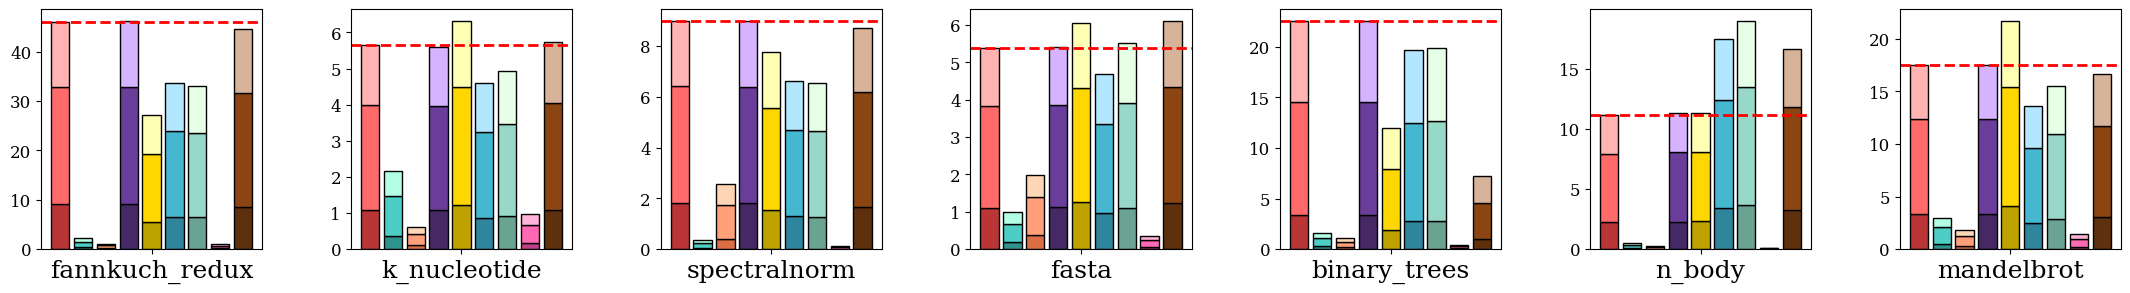

In [46]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    df = df.sort_values(by='subject')

    total_energy = df.groupby('subject')['PP0_ENERGY (KJ)'].mean()
    cache_energy = df.groupby('subject')['CACHE_ENERGY'].mean()
    dram_energy = df.groupby('subject')['DRAM_ENERGY (KJ)'].mean()

    # Plot stacked bars
    axs_flat[i].bar(total_energy.index, total_energy, label='PP0_ENERGY', color=darker_colors, edgecolor='black', linewidth=1)
    axs_flat[i].bar(cache_energy.index, cache_energy, bottom=total_energy, label='CACHE_ENERGY', color=colors, edgecolor='black',  linewidth=1)
    axs_flat[i].bar(dram_energy.index, dram_energy, bottom=total_energy + cache_energy, label='DRAM_ENERGY', color=brighter_colors, edgecolor='black',  linewidth=1)
    # Add horizontal line on top of the first bar at the left
    first_bar_height = total_energy.iloc[0] + cache_energy.iloc[0] + dram_energy.iloc[0]
    axs_flat[i].axhline(y=first_bar_height, color='red', linestyle='--', linewidth=2)
    # Set target as single x tick in the middle
    axs_flat[i].set_xticks([len(total_energy) // 2])
    axs_flat[i].set_xticklabels([targets[i]], fontsize=18)
    
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')

plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"gl2_energy_stacked.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

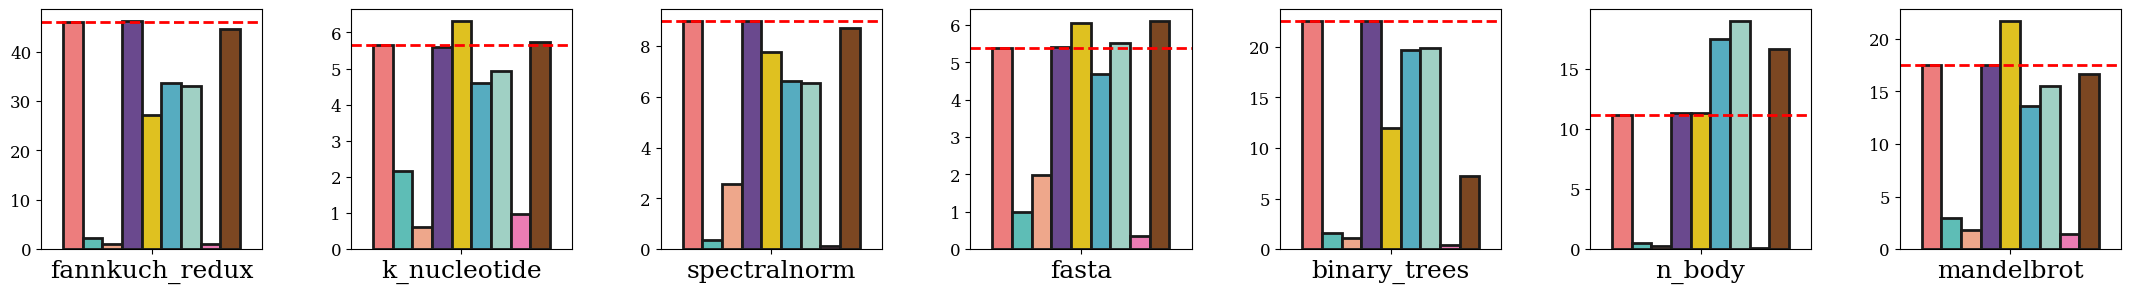

In [47]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    df.sort_values(by='subject')

    sns.barplot(
        x="target", y='TOTAL_ENERGY', hue="subject", capsize = 0.5, errorbar=None, edgecolor = '0.1', lw=2, data=df, ax = axs_flat[i], dodge=True,
        palette=colors
    )
    axs_flat[i].get_legend().remove()
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')
    axs_flat[i].tick_params(axis='x', labelsize=18)
    
    first_bar = axs_flat[i].patches[0]
    bar_height = first_bar.get_height()
    axs_flat[i].axhline(y=bar_height, color='red', linestyle='--', linewidth=2)
        
plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"gl2_energy.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

## Normality

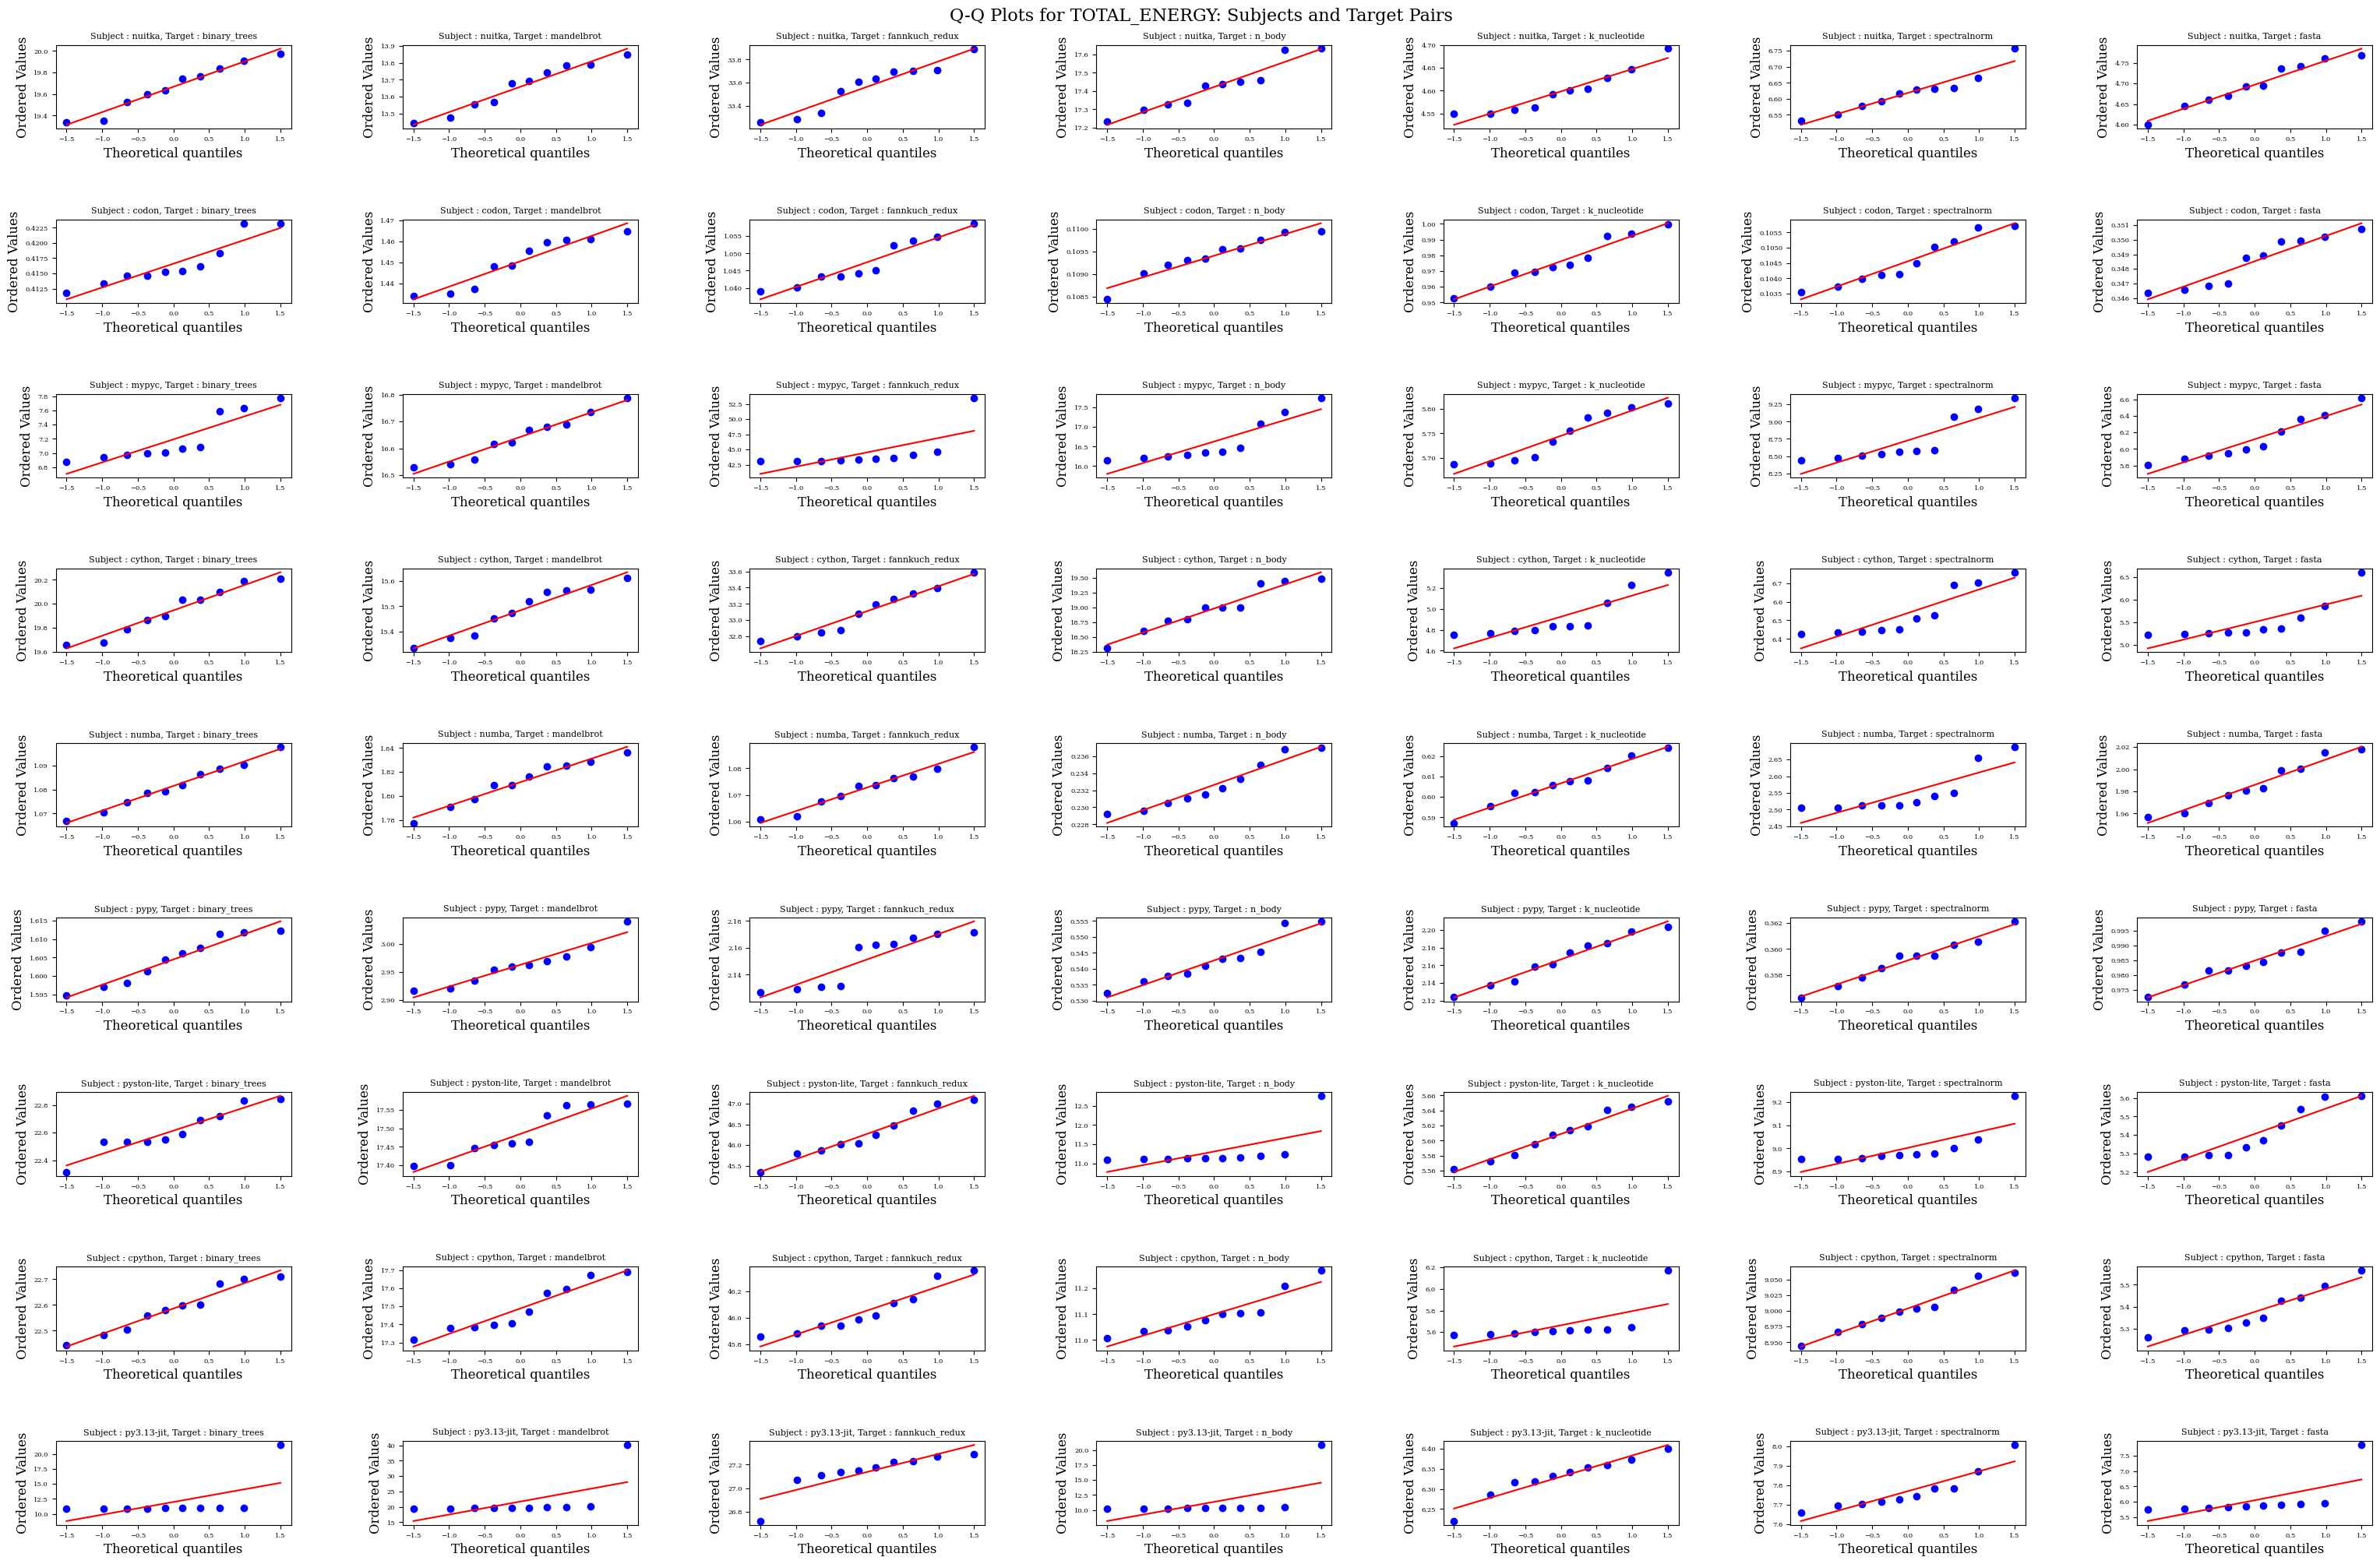

In [48]:
utils.plot_qq_grid(data, 'TOTAL_ENERGY')

### Shapiro-Wilk Aggregated 

In [49]:
from scipy import stats

In [50]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]['TOTAL_ENERGY']
    statistic, p_value = stats.shapiro(df)
    print(subject, p_value)

pypy 2.4970400260975734e-05
cpython 2.215744328428297e-09
py3.13-jit 3.276863964726432e-08
nuitka 2.2028308487439389e-07
cython 3.2627367892489854e-07
pyston-lite 2.5917296326908346e-09
mypyc 7.172690681040857e-11
codon 4.841120391729496e-07
numba 0.00017777589791145528


### Shapiro-Wilk per Benchmark

In [51]:
descriptive = []
for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)['TOTAL_ENERGY']
    statistic, p_value = stats.shapiro(df)
    row = {'subject': subject, 'target' : target, 'p-value' : p_value, 'normal?' : 'normal' if p_value > 0.05 else 'maybe not'}
    descriptive.append(row)

pd.DataFrame(descriptive)

,subject,target,p-value,normal?
0,pypy,fannkuch_redux,0.011350,maybe not
1,pypy,k_nucleotide,0.816196,normal
2,pypy,spectralnorm,0.951851,normal
3,pypy,fasta,0.899037,normal
4,pypy,binary_trees,0.364361,normal
...,...,...,...,...
58,numba,spectralnorm,0.001021,maybe not
59,numba,fasta,0.566844,normal
60,numba,binary_trees,0.986884,normal
61,numba,n_body,0.288127,normal


## Kruskal

In [52]:
from scipy.stats import kruskal

In [53]:
def calculate_kruskal(samples):
    stat, p_value = kruskal(*samples)
    return {'stat': stat, 'p_value': p_value}

In [54]:
samples = []
for subject in subjects:
    df = data[data['subject'] == subject]['TOTAL_ENERGY']
    samples.append(df.to_list())

stat, p_value = kruskal(*samples)
print({'stat': stat, 'p_value': p_value})

{'stat': 426.2813596817491, 'p_value': 4.447886093677666e-87}


## Cliffs Delta

In [55]:
from cliffs_delta import cliffs_delta